<p style='text-align: justify;'>
<strong>SENTINEL-2</strong><br>
The Copernicus Sentinel-2 mission comprises a constellation of two polar-orbiting satellites placed in the same sun-synchronous orbit, phased at 180° to each other. It aims at monitoring variability in land surface conditions, and its wide swath width (290 km) and high revisit time (10 days at the equator with one satellite, and 5 days with 2 satellites under cloud-free conditions which results in 2-3 days at mid-latitudes) will support monitoring of Earth's surface changes. The coverage limits are from between latitudes 56° south and 84° north.</p> 

<div class="alert alert-block alert-info">
<b>Tip:</b> More informatin on the characteristics of Sentinel-2 can be found <a href="https://sentinel.esa.int/web/sentinel/missions/sentinel-2"> here </a>
</div>

<font size="4" color="#01427C"  face="verdana"> <B>1. Data access: ONDA Archive</B></font>

In [1]:
# Load modules
import geopandas as gpd # loading shapefiles, storing geodata
import rasterio.mask # masking raster image by shapefiles
import glob # filepath matching
import ipywidgets as widgets # progress bar
import shapely # integrates with geopandas, create custom shapes
import numpy as np # general number manipulation
import scipy.ndimage # resampling bands with resolutions other than 10m
import xml.dom.minidom # extract metadata from sentinel2 product
import cv2 # normalize for rgb
import matplotlib.pyplot as plt # plotting data

# Hardcoded path
# Norrköping: /home/guacamole/TestImages/S2B_MSIL2A_20200811T100559_N0214_R022_T33VWF_20200811T133733.SAFE
Selected_images = ['/home/guacamole/TestImages/S2B_MSIL2A_20200811T100559_N0214_R022_T33VWF_20200811T133733.SAFE/']

In [2]:
print('The following images will be processed:\n',  '\n'.join(Selected_images))

# Bands to be processed
bands = ['**/*[2-4]_10m.jp2', '**/*[5-7]_20m.jp2', '**/*8_10m.jp2' ,'**/*8A_20m.jp2', '**/*11_20m.jp2', '**/*12_20m.jp2' ]
mtd_files = []
# Create list with absolute path 
S_files = [[] for i in range(len(Selected_images))]
for i in range(len(Selected_images)):
    for j in bands:
        S_files[i].extend(glob.glob(Selected_images[i] + j, recursive=True))
    mtd_files.extend(glob.glob(Selected_images[i] + '**/MTD_TL.xml', recursive=True))
    # if multiple, store all image paths in fullppS2, now only one

The following images will be processed:
 /home/guacamole/TestImages/S2B_MSIL2A_20200811T100559_N0214_R022_T33VWF_20200811T133733.SAFE/


<font size="4" color="#01427C"  face="verdana"> <B>2. Data Preprocessing - Sentinel-2</B></font>

In [3]:
# check mtd_file for extreme points, begin position, end position
metadata = []
for i in mtd_files:
    with xml.dom.minidom.parse(i) as dom:
        geo = dom.getElementsByTagName("Geoposition")
        ULX = int(geo[0].getElementsByTagName("ULX")[0].childNodes[0].nodeValue)
        ULY = int(geo[0].getElementsByTagName("ULY")[0].childNodes[0].nodeValue)
        geo2 = dom.getElementsByTagName("HORIZONTAL_CS_CODE")
        CS_Code = geo2[0].childNodes[0].nodeValue
        metadata.append((ULX,ULY,CS_Code))
# Use crs code taken from satellite image: CS_Code
for i in range(len(metadata)):
    print("Image #", i, "metadata:", metadata[i])

Image # 0 metadata: (499980, 6600000, 'EPSG:32633')


In [4]:
##### Study Area geometry informaiton in GeoJSON format
Images_relevant_shapes = []
for i in range(len(metadata)):
    ULX, ULY, CS_Code = metadata[i]
    d = {'geometry': [shapely.geometry.Point(ULX, ULY-1e5), shapely.geometry.Point(ULX+1e5, ULY)]}
    gdf = gpd.GeoDataFrame(d, crs=CS_Code)
    gdf = gdf.to_crs("EPSG:4619")    # Sweden's crs
    # only keep lakes intersecting with bounding box
    SwedenLake = gpd.read_file('/home/guacamole/Shapefiles/vy_y_2016_3.shp', bbox=gdf) 
    SwedenLake = SwedenLake.to_crs(CS_Code) # convert back to metadata
    Images_relevant_shapes.append(SwedenLake)

In [6]:
# Progress bar
max_count = len(S_files)*len(S_files[0])
f = widgets.IntProgress(min=0, max=max_count, description='Processing images', bar_style='info') # instantiate the bar
display(f) # display the bar
count = 0

# Mask to Study Area
S_images_mask = []
for i in range(len(S_files)):
    for j in S_files[i]:
        f.value += 1 # signal to increment the progress bar
        S_mask, out_transform = rasterio.mask.mask(rasterio.open(j), Images_relevant_shapes[i]["geometry"], crop=False, all_touched=True, filled=True) 
        S_images_mask.append(S_mask)
print('Subset...', 'DONE')

# Resample if less than half_width

# Resample to 10 m
S_imags_rspld = []
for i in range(len(S_images_mask)):
    f.value += 1
    if S_images_mask[i].shape[1] < 5600:
        img_rspld = scipy.ndimage.zoom(S_images_mask[i], zoom=(1,2,2), order=0)
        S_imags_rspld.append(img_rspld)
    else:
        S_imags_rspld.append(S_images_mask[i])
print('Resampling...', 'DONE')

IntProgress(value=0, bar_style='info', description='Processing images', max=10)

Subset... DONE
Resampling... DONE


In [8]:
# Stack images
Stk_images = np.concatenate(S_imags_rspld, axis=0)
print('Stack...', 'DONE')
print('Stack dimensions (nlayers, xres, yres):' , Stk_images.shape)

Stack... DONE
Stack dimensions (nlayers, xres, yres): (10, 10980, 10980)


<font size="4" color="#01427C"  face="verdana"> <B>4. Chlorophyll with Sentinel-2</B></font>

In [9]:
# Derive CI. Optimal bands: 443, 555, 670
ci_s2 = S_imags_rspld[1].astype('float32') - (S_imags_rspld[0].astype('float32') + (560-490)/(665-490) * (S_imags_rspld[3].astype('float32')-S_imags_rspld[0].astype('float32')))
ci_s2 = ci_s2[0,:,:]

CI DONE


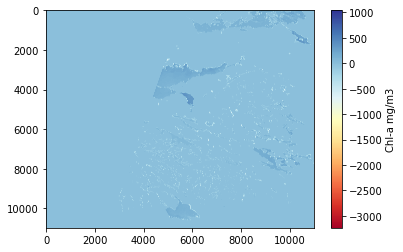

In [27]:

plt.imshow(ci_s2, aspect='auto', cmap='RdYlBu')
cbar = plt.colorbar()
cbar.set_label('Chl-a mg/m3')
#plt.ylim((1500,0))
#plt.xlim((0,1500))
plt.show()

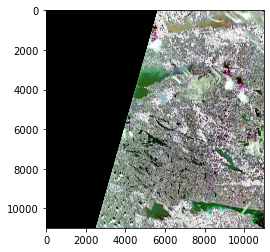

In [12]:
import matplotlib.pyplot as plt
RGB_images = []
for i in range(len(S_files)):
    RGB_images.extend(
        [rasterio.open(S_files[i][2]).read(1), # R
        rasterio.open(S_files[i][1]).read(1),  # G
        rasterio.open(S_files[i][0]).read(1)]  # B
    )
RGB_images = np.dstack((RGB_images[0], RGB_images[1], RGB_images[2]))
norm_img = np.uint8(cv2.normalize(RGB_images, None, 0, 255, cv2.NORM_MINMAX))
eq_R = cv2.equalizeHist(norm_img[:,:,0].astype(np.uint8))
eq_G = cv2.equalizeHist(norm_img[:,:,1].astype(np.uint8))
eq_B = cv2.equalizeHist(norm_img[:,:,2].astype(np.uint8))
eq_T_RGB = np.dstack((eq_B,eq_R,eq_G))
img = plt.imshow(eq_T_RGB)
plt.imsave("BRG.jpg",eq_T_RGB)

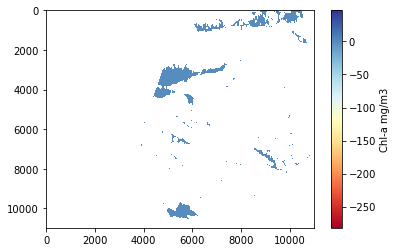

In [25]:
output_matrix = (S_imags_rspld[0].astype('float32')-S_imags_rspld[2].astype('float32'))/S_imags_rspld[1].astype('float32')
output_matrix = output_matrix[0,:,:]
plt.imshow(output_matrix, aspect='auto', cmap='RdYlBu')
cbar = plt.colorbar()
cbar.set_label('Chl-a mg/m3')
#plt.ylim((1500,0))
#plt.xlim((0,1500))
plt.show()


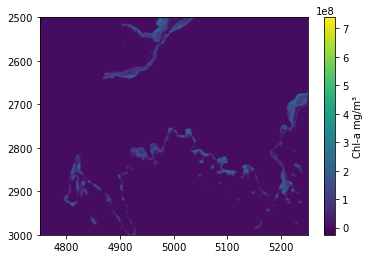

In [30]:
np.seterr(divide='ignore', invalid='ignore')
output_matrix_two =(
    S_imags_rspld[4].astype('float32')
     -S_imags_rspld[3].astype('float32')
     *((705-665)/(740/665))
     *(S_imags_rspld[5].astype('float32')-S_imags_rspld[3].astype('float32'))
)
output_matrix_two = output_matrix_two[0,:,:]

plt.imshow(output_matrix_two, aspect='auto')
cbar = plt.colorbar()
cbar.set_label('Chl-a mg/m³')
plt.ylim((3000,2500))
plt.xlim((4750,5250))
plt.show()